Entrene un autoencoder para obtener una representación de baja dimensionalidad de las imágenes de MNIST. Use dichas representaciones para entrenar un perceptrón multicapa como clasificador. ¿Cuál es el tiempo de entrenamiento y la exactitud del clasificador obtenido cuando parte de la representación del autoencoder, en comparación con lo obtenido usando las imágenes originales?

En este caso se nos permitió usar Pytorch para la parte de código. La idea es definir la estructura general de la red y luego ir modificandola hasta lograr la mejor performance. 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

# Elegir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Transformación
transform = transforms.ToTensor()

# Dataset MNIST
train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# minibatch
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=len(test_dataset))

Device: cuda


Primero una función que entrena y grafica

In [8]:
def train_and_evaluate(model, train_loader, test_loader,
                       criterion, optimizer, device,
                       num_epochs=50, patience=5, min_delta=1e-4):
    
    model = model.to(device)
    best_loss = float("inf")
    epochs_no_improve = 0
    
    history = {"train_loss": [], "test_loss": [], "accuracy": []}

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f"Parámetros entrenables: {total_params:,}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for x,y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Evaluación
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for x,y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                test_loss += criterion(outputs, y).item()
                _, pred = outputs.max(1)
                total += y.size(0)
                correct += pred.eq(y).sum().item()

        test_loss /= len(test_loader)
        accuracy = 100 * correct / total

        history["test_loss"].append(test_loss)
        history["accuracy"].append(accuracy)

        print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | "
              f"Test Loss {test_loss:.4f} | Acc {accuracy:.2f}%")

        # Early stopping
        if test_loss < best_loss - min_delta:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("✔ Early stopping activado")
            break

    # Gráficos
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["test_loss"], label="Test")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["accuracy"], label="Accuracy")
    plt.title("Accuracy (%)")
    plt.legend()
    plt.show()

    return history


In [9]:
def train_autoencoder(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            x_flat = x.view(x.size(0), -1)     #  aplanar
            optimizer.zero_grad()
            outputs = model(x_flat)
            loss = criterion(outputs, x_flat)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # evaluación
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                x_flat = x.view(x.size(0), -1)
                outputs = model(x_flat)
                loss = criterion(outputs, x_flat)
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses


La primer estructura que quiero hacer es el autoencoder. Vo a elegir una arquitectura simétrica con una reducción del 80% de tamaño de dimensión de entrada, de acuerdo al principio de Pareto, que dice que el 80% de las cosas son causadas por el 20%. Esto lo extrapolo a energía y varianza y listo. 

Entramos con $28*28$, luego a $28*28*0.5 $y luego a $0.2*28*28$. De ahí sube de vuelta

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 392)
        self.fc2 = nn.Linear(392, 156)
        self.fc3 = nn.Linear(156, 392)
        self.fc4 = nn.Linear(392, 28*28)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

model_cnn = Autoencoder().to(device)


Epoch [1/100] - Train Loss: 0.1440, Test Loss: 0.0963
Epoch [2/100] - Train Loss: 0.0904, Test Loss: 0.0851
Epoch [3/100] - Train Loss: 0.0822, Test Loss: 0.0788
Epoch [4/100] - Train Loss: 0.0781, Test Loss: 0.0761
Epoch [5/100] - Train Loss: 0.0757, Test Loss: 0.0744
Epoch [6/100] - Train Loss: 0.0741, Test Loss: 0.0730
Epoch [7/100] - Train Loss: 0.0728, Test Loss: 0.0720
Epoch [8/100] - Train Loss: 0.0718, Test Loss: 0.0713
Epoch [9/100] - Train Loss: 0.0710, Test Loss: 0.0708
Epoch [10/100] - Train Loss: 0.0704, Test Loss: 0.0701
Epoch [11/100] - Train Loss: 0.0698, Test Loss: 0.0696
Epoch [12/100] - Train Loss: 0.0694, Test Loss: 0.0692
Epoch [13/100] - Train Loss: 0.0689, Test Loss: 0.0689
Epoch [14/100] - Train Loss: 0.0686, Test Loss: 0.0683
Epoch [15/100] - Train Loss: 0.0683, Test Loss: 0.0680
Epoch [16/100] - Train Loss: 0.0680, Test Loss: 0.0682
Epoch [17/100] - Train Loss: 0.0678, Test Loss: 0.0677
Epoch [18/100] - Train Loss: 0.0675, Test Loss: 0.0675
Epoch [19/100] - Tr

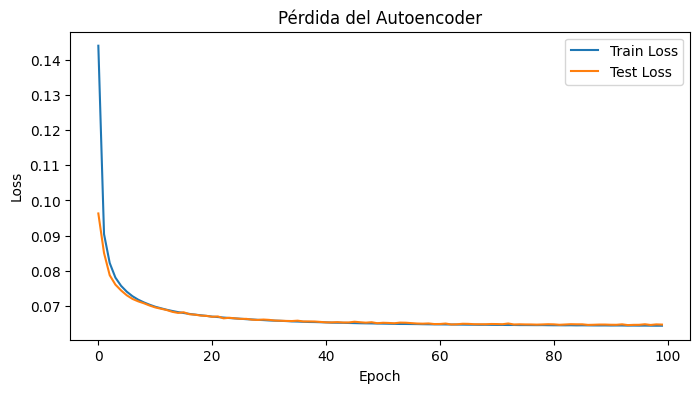

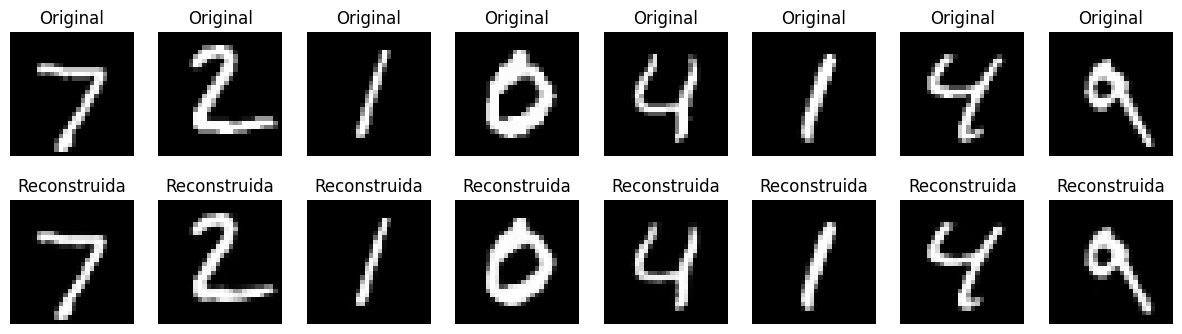

In [11]:
# -------- Entrenamiento --------
criterion = nn.BCELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

train_losses, test_losses = train_autoencoder(
    model_cnn, train_loader, test_loader,
    criterion, optimizer, device,
    num_epochs=100
)


# -------- Gráficos --------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Autoencoder')
plt.show()


# -------- Visualizar reconstrucciones --------
model_cnn.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        x_flat = x.view(x.size(0), -1)
        outputs = model_cnn(x_flat)
        break  # solo un batch

# convertir a imágenes
x = x.cpu().view(-1, 1, 28, 28)
outputs = outputs.cpu().view(-1, 1, 28, 28)

# mostrar algunas imágenes
n = 8
plt.figure(figsize=(15,4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i][0], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i][0], cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.show()

1570 parámetros no congelados, la capa de 156 a 10 + bias

In [ ]:
class ClassifierFromEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes=10):
        super().__init__()
        # acá tomamos las capas del otro modelo y las congelamos
        self.encoder_fc1 = autoencoder.fc1
        self.encoder_fc2 = autoencoder.fc2
        for param in self.encoder_fc1.parameters():
            param.requires_grad = False
        for param in self.encoder_fc2.parameters():
            param.requires_grad = False
        self.classifier = nn.Linear(156, num_classes) # lo más simple posible

    def forward(self, x):
        x = x.view(x.size(0), -1)
        with torch.no_grad():
            x = F.relu(self.encoder_fc1(x))
            encoded = F.relu(self.encoder_fc2(x))
        logits = self.classifier(encoded)
        return logits

classifier_model = ClassifierFromEncoder(model_cnn).to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier_model.classifier.parameters(), lr=1e-3)

# ------------------------
# Entrenamiento Clasificador
# ------------------------
num_epochs_cls = 100
for epoch in range(num_epochs_cls):
    classifier_model.train()
    running_loss = 0
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier_model(x)
        loss = criterion_cls(outputs, y)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cls} | Loss={running_loss/len(train_loader):.4f} | Acc={train_acc:.2f}%")

# ------------------------
# Evaluación en Test
# ------------------------
classifier_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct/total:.2f}%")



# Evaluación por dígito
classifier_model.eval()
confusion_matrix = torch.zeros(10, 10)
digit_totals = torch.zeros(10)
digit_correct = torch.zeros(10)
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        
        # Contadores globales
        total_correct += (pred == y).sum().item()
        total_samples += y.size(0)
        
        # Contadores por dígito
        for t, p in zip(y.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            digit_totals[t.long()] += 1
            if t == p:
                digit_correct[t.long()] += 1

# Calcular ambas métricas
digit_accuracy = (digit_correct / digit_totals) * 100
average_accuracy = digit_accuracy.mean()
global_accuracy = (total_correct / total_samples) * 100

print("Accuracy por dígito:")
print("-" * 30)
for digit in range(10):
    print(f"Dígito {digit}: {digit_accuracy[digit]:.2f}% ({digit_totals[digit]:.0f} muestras)")
print("-" * 30)
print(f"Accuracy promedio (media de accuracies): {average_accuracy:.2f}%")
print(f"Accuracy global (total correctos/total muestras): {global_accuracy:.2f}%")

Epoch 1/100 | Loss=0.7307 | Acc=80.71%
Epoch 2/100 | Loss=0.3719 | Acc=89.63%
Epoch 3/100 | Loss=0.3321 | Acc=90.47%
Epoch 4/100 | Loss=0.3143 | Acc=90.88%
Epoch 5/100 | Loss=0.3054 | Acc=91.16%
Epoch 6/100 | Loss=0.2997 | Acc=91.23%
Epoch 7/100 | Loss=0.2950 | Acc=91.32%
Epoch 8/100 | Loss=0.2923 | Acc=91.53%
Epoch 9/100 | Loss=0.2911 | Acc=91.49%
Epoch 10/100 | Loss=0.2894 | Acc=91.58%
Epoch 11/100 | Loss=0.2887 | Acc=91.55%
Epoch 12/100 | Loss=0.2874 | Acc=91.56%
Epoch 13/100 | Loss=0.2870 | Acc=91.64%
Epoch 14/100 | Loss=0.2863 | Acc=91.69%
Epoch 15/100 | Loss=0.2859 | Acc=91.63%
Epoch 16/100 | Loss=0.2845 | Acc=91.66%
Epoch 17/100 | Loss=0.2842 | Acc=91.75%
Epoch 18/100 | Loss=0.2851 | Acc=91.71%
Epoch 19/100 | Loss=0.2838 | Acc=91.77%
Epoch 20/100 | Loss=0.2850 | Acc=91.65%
Epoch 21/100 | Loss=0.2838 | Acc=91.67%
Epoch 22/100 | Loss=0.2836 | Acc=91.68%
Epoch 23/100 | Loss=0.2834 | Acc=91.72%
Epoch 24/100 | Loss=0.2833 | Acc=91.73%
Epoch 25/100 | Loss=0.2832 | Acc=91.73%
Epoch 26/

In [15]:
class ClassifierSinEncoder(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(28*28, num_classes) # conexión directa de imagen a clases

    def forward(self, x):
        x = x.view(x.size(0), -1)  # aplanar la imagen
        logits = self.classifier(x)
        return logits

# Crear modelo y moverlo al dispositivo
classifier_model = ClassifierSinEncoder().to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier_model.parameters(), lr=1e-3)

# ------------------------
# Entrenamiento Clasificador
# ------------------------
num_epochs_cls = 100
for epoch in range(num_epochs_cls):
    classifier_model.train()
    running_loss = 0
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier_model(x)
        loss = criterion_cls(outputs, y)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cls} | Loss={running_loss/len(train_loader):.4f} | Acc={train_acc:.2f}%")


# ------------------------
# Evaluación en Test
# ------------------------
classifier_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct/total:.2f}%")



# Evaluación por dígito
classifier_model.eval()
confusion_matrix = torch.zeros(10, 10)
digit_totals = torch.zeros(10)
digit_correct = torch.zeros(10)
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        
        # Contadores globales
        total_correct += (pred == y).sum().item()
        total_samples += y.size(0)
        
        # Contadores por dígito
        for t, p in zip(y.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            digit_totals[t.long()] += 1
            if t == p:
                digit_correct[t.long()] += 1

# Calcular ambas métricas
digit_accuracy = (digit_correct / digit_totals) * 100
average_accuracy = digit_accuracy.mean()
global_accuracy = (total_correct / total_samples) * 100

print("Accuracy por dígito:")
print("-" * 30)
for digit in range(10):
    print(f"Dígito {digit}: {digit_accuracy[digit]:.2f}% ({digit_totals[digit]:.0f} muestras)")
print("-" * 30)
print(f"Accuracy promedio (media de accuracies): {average_accuracy:.2f}%")
print(f"Accuracy global (total correctos/total muestras): {global_accuracy:.2f}%")

Epoch 1/100 | Loss=0.5398 | Acc=87.04%
Epoch 2/100 | Loss=0.3229 | Acc=91.07%
Epoch 3/100 | Loss=0.2953 | Acc=91.79%
Epoch 4/100 | Loss=0.2819 | Acc=92.12%
Epoch 5/100 | Loss=0.2736 | Acc=92.32%
Epoch 6/100 | Loss=0.2678 | Acc=92.57%
Epoch 7/100 | Loss=0.2634 | Acc=92.61%
Epoch 8/100 | Loss=0.2599 | Acc=92.80%
Epoch 9/100 | Loss=0.2570 | Acc=92.92%
Epoch 10/100 | Loss=0.2550 | Acc=92.92%
Epoch 11/100 | Loss=0.2523 | Acc=93.01%
Epoch 12/100 | Loss=0.2510 | Acc=92.99%
Epoch 13/100 | Loss=0.2492 | Acc=93.08%
Epoch 14/100 | Loss=0.2481 | Acc=93.16%
Epoch 15/100 | Loss=0.2464 | Acc=93.19%
Epoch 16/100 | Loss=0.2456 | Acc=93.18%
Epoch 17/100 | Loss=0.2445 | Acc=93.28%
Epoch 18/100 | Loss=0.2437 | Acc=93.29%
Epoch 19/100 | Loss=0.2422 | Acc=93.31%
Epoch 20/100 | Loss=0.2418 | Acc=93.33%
Epoch 21/100 | Loss=0.2409 | Acc=93.40%
Epoch 22/100 | Loss=0.2403 | Acc=93.37%
Epoch 23/100 | Loss=0.2396 | Acc=93.42%
Epoch 24/100 | Loss=0.2387 | Acc=93.45%
Epoch 25/100 | Loss=0.2382 | Acc=93.45%
Epoch 26/

In [ ]:
class ClassifierFromEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes=10):
        super().__init__()
        # Capas del encoder congeladas
        self.encoder_fc1 = autoencoder.fc1
        self.encoder_fc2 = autoencoder.fc2
        for param in self.encoder_fc1.parameters():
            param.requires_grad = False
        for param in self.encoder_fc2.parameters():
            param.requires_grad = False
        
        # Capas del clasificador
        self.classifier1 = nn.Linear(156, 156)  # Nueva capa oculta
        self.classifier2 = nn.Linear(156, num_classes)  # Capa de salida

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Encoder congelado
        with torch.no_grad():
            x = F.relu(self.encoder_fc1(x))
            encoded = F.relu(self.encoder_fc2(x))
        # Clasificador entrenable
        x = F.relu(self.classifier1(encoded))
        logits = self.classifier2(x)
        return logits

classifier_model = ClassifierFromEncoder(model_cnn).to(device)
criterion_cls = nn.CrossEntropyLoss()
# Optimizador solo con parámetros de las capas classifier
optimizer_cls = optim.Adam([
    *classifier_model.classifier1.parameters(),
    *classifier_model.classifier2.parameters()
], lr=1e-3)
# ------------------------
# Entrenamiento Clasificador
# ------------------------
num_epochs_cls = 100
for epoch in range(num_epochs_cls):
    classifier_model.train()
    running_loss = 0
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier_model(x)
        loss = criterion_cls(outputs, y)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cls} | Loss={running_loss/len(train_loader):.4f} | Acc={train_acc:.2f}%")

# ------------------------
# Evaluación en Test
# ------------------------
classifier_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct/total:.2f}%")



# Evaluación por dígito
classifier_model.eval()
confusion_matrix = torch.zeros(10, 10)
digit_totals = torch.zeros(10)
digit_correct = torch.zeros(10)
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        
        # Contadores globales
        total_correct += (pred == y).sum().item()
        total_samples += y.size(0)
        
        # Contadores por dígito
        for t, p in zip(y.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            digit_totals[t.long()] += 1
            if t == p:
                digit_correct[t.long()] += 1

# Calcular ambas métricas
digit_accuracy = (digit_correct / digit_totals) * 100
average_accuracy = digit_accuracy.mean()
global_accuracy = (total_correct / total_samples) * 100

print("Accuracy por dígito:")
print("-" * 30)
for digit in range(10):
    print(f"Dígito {digit}: {digit_accuracy[digit]:.2f}% ({digit_totals[digit]:.0f} muestras)")
print("-" * 30)
print(f"Accuracy promedio (media de accuracies): {average_accuracy:.2f}%")
print(f"Accuracy global (total correctos/total muestras): {global_accuracy:.2f}%")

In [ ]:
class ClassifierFromEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes=10):
        super().__init__()
        # Solo copiamos las capas, sin congelarlas
        self.encoder_fc1 = autoencoder.fc1
        self.encoder_fc2 = autoencoder.fc2
        self.classifier = nn.Linear(156, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Sin torch.no_grad()
        x = F.relu(self.encoder_fc1(x))
        encoded = F.relu(self.encoder_fc2(x))
        logits = self.classifier(encoded)
        return logits

classifier_model = ClassifierFromEncoder(model_cnn).to(device)
criterion_cls = nn.CrossEntropyLoss()
# Optimizador con todos los parámetros
optimizer_cls = optim.Adam(classifier_model.parameters(), lr=1e-3)


# ------------------------
# Entrenamiento Clasificador
# ------------------------
num_epochs_cls = 100
for epoch in range(num_epochs_cls):
    classifier_model.train()
    running_loss = 0
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier_model(x)
        loss = criterion_cls(outputs, y)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs_cls} | Loss={running_loss/len(train_loader):.4f} | Acc={train_acc:.2f}%")

# ------------------------
# Evaluación en Test
# ------------------------
classifier_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct/total:.2f}%")



# Evaluación por dígito
classifier_model.eval()
confusion_matrix = torch.zeros(10, 10)
digit_totals = torch.zeros(10)
digit_correct = torch.zeros(10)
total_correct = 0
total_samples = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier_model(x)
        _, pred = outputs.max(1)
        
        # Contadores globales
        total_correct += (pred == y).sum().item()
        total_samples += y.size(0)
        
        # Contadores por dígito
        for t, p in zip(y.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
            digit_totals[t.long()] += 1
            if t == p:
                digit_correct[t.long()] += 1

# Calcular ambas métricas
digit_accuracy = (digit_correct / digit_totals) * 100
average_accuracy = digit_accuracy.mean()
global_accuracy = (total_correct / total_samples) * 100

print("Accuracy por dígito:")
print("-" * 30)
for digit in range(10):
    print(f"Dígito {digit}: {digit_accuracy[digit]:.2f}% ({digit_totals[digit]:.0f} muestras)")
print("-" * 30)
print(f"Accuracy promedio (media de accuracies): {average_accuracy:.2f}%")
print(f"Accuracy global (total correctos/total muestras): {global_accuracy:.2f}%")